# MIA Evaluation

In [1]:
import os
import torch
from torch import nn
import torchinfo
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2 as cv
from tqdm import tqdm
# from pycocotools.coco import COCO

# scripts
from training import get_transform_list, get_dataset, CombinedDataset, Subset, get_distilgpt2_srn18_vae, seed_torch

os.environ["CUDA_VISIBLE_DEVICES"] = '0'


In [2]:
from scipy.spatial.distance import cosine, euclidean, cityblock, chebyshev, braycurtis, canberra

In [3]:
SEED = 13
DATA_DIR = "data/mscoco"

transform_list = get_transform_list()

# get datasets
train_ds = get_dataset(transform_list, dataset_type="train2014", data_dir=DATA_DIR, seed=SEED)
test_ds = get_dataset(transform_list, dataset_type="test2014", data_dir=DATA_DIR, seed=SEED)


loading annotations into memory...
Done (t=0.31s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [4]:
print('train:\t', len(train_ds))
print('test:\t', len(test_ds))

train:	 82783
test:	 40775


In [6]:
class CombinedDataset(torch.utils.data.Dataset):
    """
    Create a torch.utils.data.Dataset subclass so we can combine our train/test
    datasets to infer membership status with MIA
    """
    def __init__(self, dataset_a, dataset_b, label_a: int, label_b: int):
        self.dataset_a = dataset_a
        self.dataset_b = dataset_b
        
        self.length_a = len(dataset_a)
        self.length_b = len(dataset_b)
        
        self.label_a = label_a
        self.label_b = label_b

    def __len__(self):
        return self.length_a + self.length_b

    def __getitem__(self, idx):
        if idx < self.length_a:
            # get item from dataset a
            img = self.dataset_a[idx]['image']
            label = torch.tensor(self.label_a)
        else:
            # get item from dataset a
            img = self.dataset_b[idx - self.length_a]['image']
            label = torch.tensor(self.label_b)
            
        return {"image": img, "index": idx, "label": label}



In [8]:
random_gen = random.Random(SEED)

# Generate random indices
n_subset = 300
train_idxs = random_gen.sample(range(len(train_ds)), n_subset)
test_idxs = random_gen.sample(range(len(test_ds)), n_subset)

# sample subsets
train_subset = torch.utils.data.Subset(train_ds, train_idxs)
test_subset = torch.utils.data.Subset(test_ds, test_idxs)

mia_ds = CombinedDataset(train_subset, test_subset, 1, 0)
len(mia_ds)

600

In [9]:
def get_transform_list(enabled_list: list | None = None, max_size: int = 128):
    transform_dict = {
        "spatial": [
            v2.RandomHorizontalFlip(0.4),
            v2.RandomVerticalFlip(0.4),
            v2.RandomRotation(50),
            v2.RandomResizedCrop(size=(max_size, 128), scale=(0.7, 1.0)),
        ],
        "noise": [
            v2.GaussianNoise(),
        ],
        "color": [
            v2.ColorJitter(
                brightness=(0.6, 1.4),
                contrast=(0.6, 1.4),
                saturation=(0.6, 1.4),
                hue=(-0.2, 0.2),
            ),
        ]
    }
    # by default use all
    if enabled_list is None:
        enabled_list = list(transform_dict.keys())

    # only retain selected transform types
    transform_dict = {k:v for k,v in transform_dict.items() if k in enabled_list}
    # unpack transforms and compose
    return v2.Compose([transform for transform_type in transform_dict.values() for transform in transform_type])


def torch_to_plt(img, to_uint8: bool = False):
    if to_uint8:
        return cv.cvtColor(np.moveaxis((img.numpy()*255).astype(np.uint8), 0, 2), cv.COLOR_BGR2RGB)
    else:
        return cv.cvtColor(np.moveaxis(img.numpy(), 0, 2), cv.COLOR_BGR2RGB)



# Augmentation Testing

## Spatial Augments

original


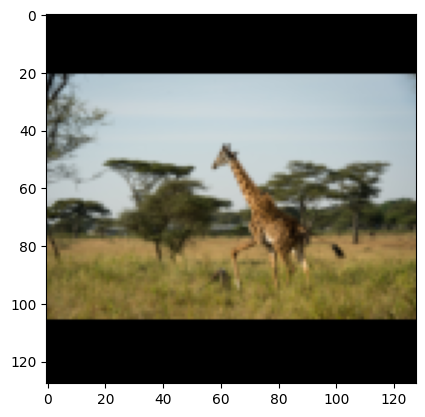

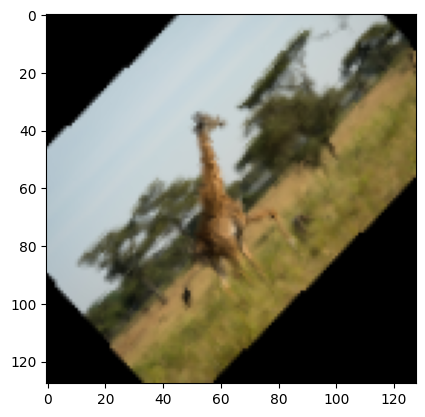

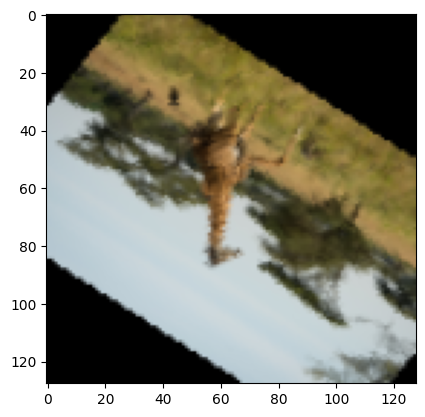

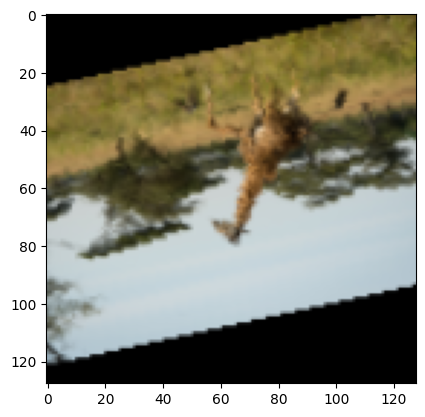

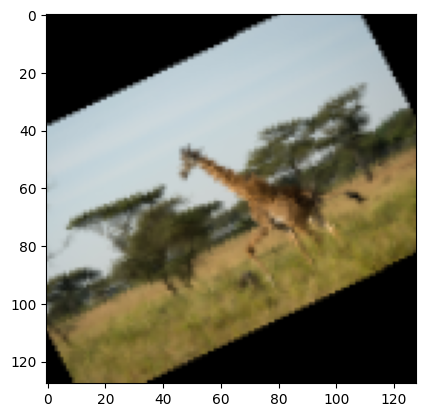

In [35]:

transform_list = get_transform_list(['spatial'])
test_img = mia_ds[0]['image']

print('original')
plt.imshow(torch_to_plt(test_img))
plt.show()

for _ in range(4):
    aug_img = transform_list(test_img)
    plt.imshow(torch_to_plt(aug_img))
    plt.show()

## Color Augments

original


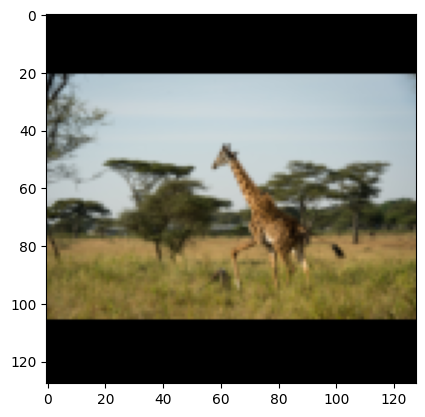

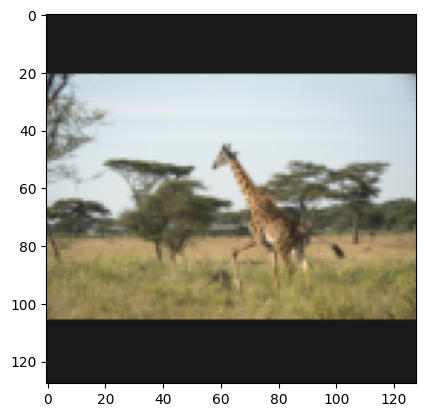

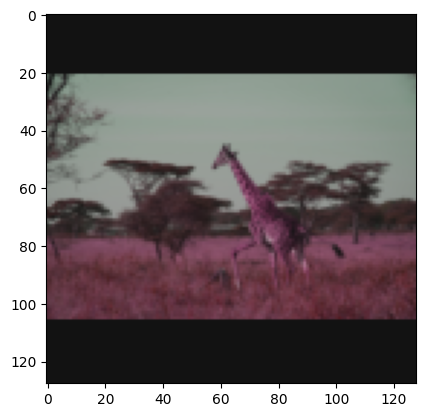

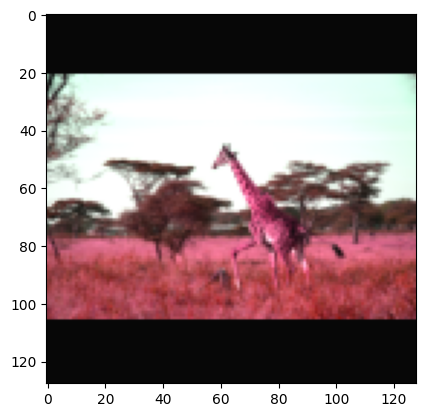

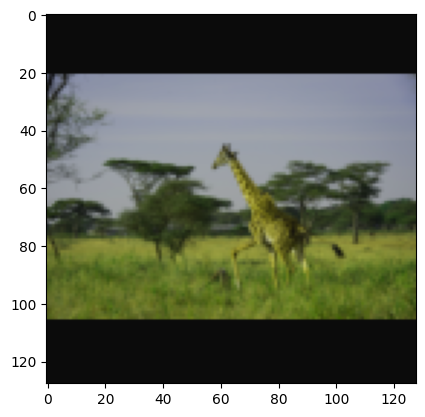

In [42]:

transform_list = get_transform_list(['color'])
test_img = mia_ds[0]['image']

print('original')
plt.imshow(torch_to_plt(test_img))
plt.show()

for _ in range(4):
    aug_img = transform_list(test_img)
    plt.imshow(torch_to_plt(aug_img))
    plt.show()

## Noise Augments

original


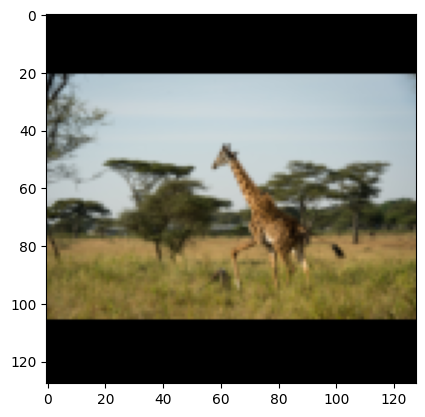

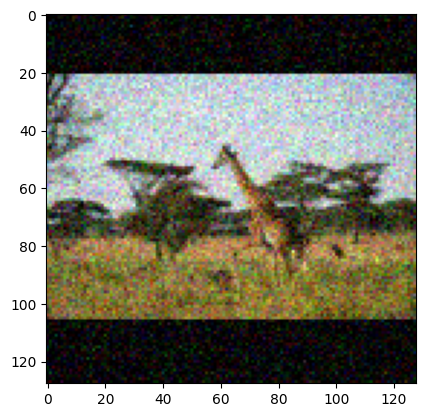

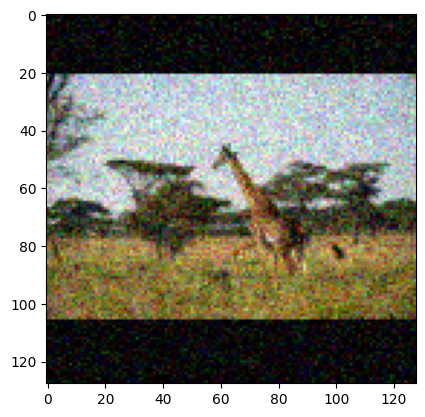

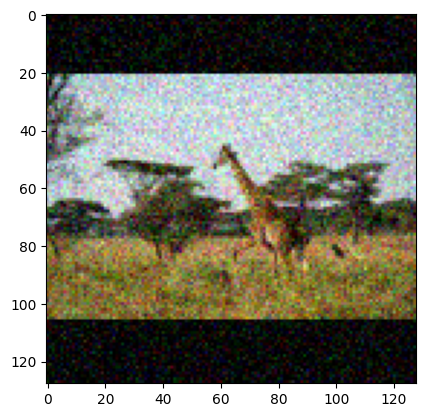

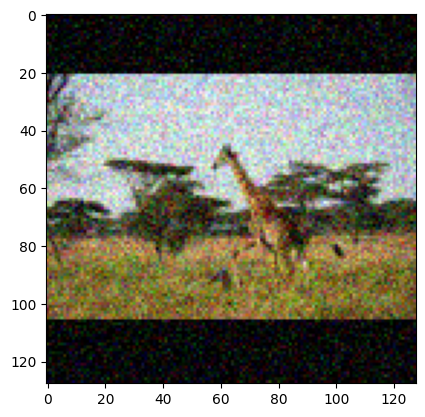

In [37]:

transform_list = get_transform_list(['noise'])
test_img = mia_ds[0]['image']

print('original')
plt.imshow(torch_to_plt(test_img))
plt.show()

for _ in range(4):
    aug_img = transform_list(test_img)
    plt.imshow(torch_to_plt(aug_img))
    plt.show()

# Augmented Set Generation

In [10]:
import os
import torch
from torch.utils.data import Dataset
from torchvision.transforms import v2
from pathlib import Path
import pickle
from tqdm.auto import tqdm

class AugmentedDataset(Dataset):
    def __init__(self, original_dataset=None, transform_list=None, num_augmentations=None, save_dir=None, load_file=None):
        """
        Args:
            original_dataset (Dataset): The original PyTorch dataset.
            transform_list (Compose): Composed list of PyTorch v2 transforms.
            num_augmentations (int): Number of augmentations to generate per image.
            save_dir (str): Directory to save the augmented dataset.
            load_file (str): Path to a file to load a saved dataset state.
        """
        self.original_dataset = original_dataset
        self.transforms = transform_list
        self._getitem_transforms = v2.Compose([
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
        ])
        self.num_augmentations = num_augmentations
        self.save_dir = save_dir
        if self.save_dir is not None:
            Path(self.save_dir).mkdir(parents=True, exist_ok=True)

        if load_file:
            self._load_state(load_file)
        else:
            if not (original_dataset and transform_list and num_augmentations and save_dir):
                raise ValueError("original_dataset, transform_list, num_augmentations, and save_dir must be provided if not loading from a file.")

            # Create save directory if it doesn't exist
            os.makedirs(save_dir, exist_ok=True)

            # Prepare a mapping of new indices to original indices
            self.index_map = []
            self._prepare_dataset()

    def _prepare_dataset(self):
        """Prepares the dataset by saving augmented and original images."""
        idx = 0
        for original_idx in tqdm(range(len(self.original_dataset))):
            # Save the original image
            original_data = self.original_dataset[original_idx]
            image, label = original_data['image'], original_data['label']
            image_path = os.path.join(self.save_dir, f"image_{idx}.png")
            cv.imwrite(image_path, torch_to_plt(image, to_uint8=True))
            # image.save(image_path)
            self.index_map.append({
                'idx': idx,
                'original_idx': original_idx,
                'modified': False,
                'label': label
            })
            idx += 1

            # Save augmented images
            for _ in range(self.num_augmentations):
                augmented_image = self.transforms(image)
                augmented_image_path = os.path.join(self.save_dir, f"image_{idx}.png")
                cv.imwrite(augmented_image_path, torch_to_plt(augmented_image, to_uint8=True))
                self.index_map.append({
                    'idx': idx,
                    'original_idx': original_idx,
                    'modified': True,
                    'label': label
                })
                idx += 1

    def _save_state(self, file_path):
        """Saves the dataset state to a file."""
        state = {
            'index_map': self.index_map,
            'save_dir': self.save_dir
        }
        with open(file_path, 'wb') as f:
            pickle.dump(state, f)

    def _load_state(self, file_path):
        """Loads the dataset state from a file."""
        with open(file_path, 'rb') as f:
            state = pickle.load(f)
        self.index_map = state['index_map']
        self.save_dir = state['save_dir']

    def __len__(self):
        return len(self.index_map)

    def __getitem__(self, idx):
        """Fetches the image and metadata for the given index."""
        metadata = self.index_map[idx]
                    
        image_path = os.path.join(self.save_dir, f"image_{metadata['idx']}.png")
        image = cv.imread(image_path)
        image = self._getitem_transforms(image)
        return {
            'image': image,
            'idx': metadata['idx'],
            'original_idx': metadata['original_idx'],
            'label': metadata['label'],
            'modified': metadata['modified']
        }



In [11]:
# generate augmented datasets
ds_dict = dict()
for transform_type in ['spatial', 'color', 'noise']:
    print(f'generating {transform_type} dataset')
    transform_list = get_transform_list([transform_type])
    num_augmentations = 5
    save_dir = f"data/augmented_{transform_type}"
    save_file = f"data/augmented_{transform_type}_state.pkl"
    
    # create and save dataset
    ds_dict[transform_type] = AugmentedDataset(mia_ds, transform_list, num_augmentations, save_dir)
    ds_dict[transform_type]._save_state(save_file)

generating {transform_type} dataset


  0%|          | 0/600 [00:00<?, ?it/s]

generating {transform_type} dataset


  0%|          | 0/600 [00:00<?, ?it/s]

generating {transform_type} dataset


  0%|          | 0/600 [00:00<?, ?it/s]

In [17]:
# Load dataset from saved state
# loaded_dataset = AugmentedDataset(load_file=save_file)

# Model Inference

In [13]:
device = 'cuda'
param_dict = {
	'captioner_weights': "logs/tests/srn18_vae_dgpt2_z3/best.pth",
	'mixed_precision': 1,
    'freeze_encoder': 0, # only affects things if ur finetuning the model
}

model = get_distilgpt2_srn18_vae(param_dict)
model.eval()
model.to(device)

loading captioner weights from: logs/tests/srn18_vae_dgpt2_z3/best.pth


ImageCaptioner(
  (encoder): VariationalEncoder(
    (encoder): SepResNet18(
      (encoder): SepResNetEncoder(
        (conv_1): DepthwiseSeparableConv2d(
          (depthwise_conv): Conv2d(3, 3, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), groups=3)
          (pointwise_conv): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
        )
        (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (block_1): ResidualBlock(
          (subblocks): Sequential(
            (0): ResidualSubBlock(
              (main): StandardMainPath(
                (bn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (act_1): ReLU()
                (conv_1): DepthwiseSeparableConv2d(
                  (depthwise_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
                  (pointwise_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
                )
           

In [14]:
# run inference on augmented datasets
inference_dict = dict()

for transform_type in ['spatial', 'color', 'noise']:
    print(f'running inference on {transform_type} dataset')
    curr_dataset = ds_dict[transform_type]
    output_list = model.generate_batch_captions(curr_dataset, max_workers=32)
    inference_dict[transform_type] = output_list



running inference on spatial dataset
started generation supervisor...


main:   0%|          | 0/3600 [00:00<?, ?it/s]

[w:   0] [i: ?] |            | , status=starting up

[w:   1] [i: ?] |            | , status=starting up

[w:   2] [i: ?] |            | , status=starting up

[w:   3] [i: ?] |            | , status=starting up

[w:   4] [i: ?] |            | , status=starting up

[w:   5] [i: ?] |            | , status=starting up

[w:   6] [i: ?] |            | , status=starting up

[w:   7] [i: ?] |            | , status=starting up

[w:   8] [i: ?] |            | , status=starting up

[w:   9] [i: ?] |            | , status=starting up

[w:  10] [i: ?] |            | , status=starting up

[w:  11] [i: ?] |            | , status=starting up

[w:  12] [i: ?] |            | , status=starting up

[w:  13] [i: ?] |            | , status=starting up

[w:  14] [i: ?] |            | , status=starting up

[w:  15] [i: ?] |            | , status=starting up

[w:  16] [i: ?] |            | , status=starting up

[w:  17] [i: ?] |            | , status=starting up

[w:  18] [i: ?] |            | , status=starting up

[w:  19] [i: ?] |            | , status=starting up

[w:  20] [i: ?] |            | , status=starting up

[w:  21] [i: ?] |            | , status=starting up

[w:  22] [i: ?] |            | , status=starting up

[w:  23] [i: ?] |            | , status=starting up

[w:  24] [i: ?] |            | , status=starting up

[w:  25] [i: ?] |            | , status=starting up

[w:  26] [i: ?] |            | , status=starting up

[w:  27] [i: ?] |            | , status=starting up

[w:  28] [i: ?] |            | , status=starting up

[w:  29] [i: ?] |            | , status=starting up

[w:  30] [i: ?] |            | , status=starting up

[w:  31] [i: ?] |            | , status=starting up

running inference on color dataset
started generation supervisor...


main:   0%|          | 0/3600 [00:00<?, ?it/s]

[w:   0] [i: ?] |            | , status=starting up

[w:   1] [i: ?] |            | , status=starting up

[w:   2] [i: ?] |            | , status=starting up

[w:   3] [i: ?] |            | , status=starting up

[w:   4] [i: ?] |            | , status=starting up

[w:   5] [i: ?] |            | , status=starting up

[w:   6] [i: ?] |            | , status=starting up

[w:   7] [i: ?] |            | , status=starting up

[w:   8] [i: ?] |            | , status=starting up

[w:   9] [i: ?] |            | , status=starting up

[w:  10] [i: ?] |            | , status=starting up

[w:  11] [i: ?] |            | , status=starting up

[w:  12] [i: ?] |            | , status=starting up

[w:  13] [i: ?] |            | , status=starting up

[w:  14] [i: ?] |            | , status=starting up

[w:  15] [i: ?] |            | , status=starting up

[w:  16] [i: ?] |            | , status=starting up

[w:  17] [i: ?] |            | , status=starting up

[w:  18] [i: ?] |            | , status=starting up

[w:  19] [i: ?] |            | , status=starting up

[w:  20] [i: ?] |            | , status=starting up

[w:  21] [i: ?] |            | , status=starting up

[w:  22] [i: ?] |            | , status=starting up

[w:  23] [i: ?] |            | , status=starting up

[w:  24] [i: ?] |            | , status=starting up

[w:  25] [i: ?] |            | , status=starting up

[w:  26] [i: ?] |            | , status=starting up

[w:  27] [i: ?] |            | , status=starting up

[w:  28] [i: ?] |            | , status=starting up

[w:  29] [i: ?] |            | , status=starting up

[w:  30] [i: ?] |            | , status=starting up

[w:  31] [i: ?] |            | , status=starting up

running inference on noise dataset
started generation supervisor...


main:   0%|          | 0/3600 [00:00<?, ?it/s]

[w:   0] [i: ?] |            | , status=starting up

[w:   1] [i: ?] |            | , status=starting up

[w:   2] [i: ?] |            | , status=starting up

[w:   3] [i: ?] |            | , status=starting up

[w:   4] [i: ?] |            | , status=starting up

[w:   5] [i: ?] |            | , status=starting up

[w:   6] [i: ?] |            | , status=starting up

[w:   7] [i: ?] |            | , status=starting up

[w:   8] [i: ?] |            | , status=starting up

[w:   9] [i: ?] |            | , status=starting up

[w:  10] [i: ?] |            | , status=starting up

[w:  11] [i: ?] |            | , status=starting up

[w:  12] [i: ?] |            | , status=starting up

[w:  13] [i: ?] |            | , status=starting up

[w:  14] [i: ?] |            | , status=starting up

[w:  15] [i: ?] |            | , status=starting up

[w:  16] [i: ?] |            | , status=starting up

[w:  17] [i: ?] |            | , status=starting up

[w:  18] [i: ?] |            | , status=starting up

[w:  19] [i: ?] |            | , status=starting up

[w:  20] [i: ?] |            | , status=starting up

[w:  21] [i: ?] |            | , status=starting up

[w:  22] [i: ?] |            | , status=starting up

[w:  23] [i: ?] |            | , status=starting up

[w:  24] [i: ?] |            | , status=starting up

[w:  25] [i: ?] |            | , status=starting up

[w:  26] [i: ?] |            | , status=starting up

[w:  27] [i: ?] |            | , status=starting up

[w:  28] [i: ?] |            | , status=starting up

[w:  29] [i: ?] |            | , status=starting up

[w:  30] [i: ?] |            | , status=starting up

[w:  31] [i: ?] |            | , status=starting up

In [15]:
# save augmented data inferences
for transform_type in ['spatial', 'color', 'noise']:
    pickle_file_path = f"lsa_{transform_type}_mia10k.pickle"
    print(f'saving {transform_type} inference data to {pickle_file_path}')
    
    with open(pickle_file_path, 'wb') as handle:
        pickle.dump(inference_dict[transform_type], handle, protocol=pickle.HIGHEST_PROTOCOL)

saving spatial dataset to lsa_spatial_mia10k.pickle
saving color dataset to lsa_color_mia10k.pickle
saving noise dataset to lsa_noise_mia10k.pickle


In [ ]:
# link items in inference_dict[transform_type]
# to their corresponding items in ds_dict[transform_type]
# 'idx' (augmented_ds index)

In [ ]:
class LSAImage:
    def __init__(self, lsa: list):
        _lsa = lsa.copy() # make sure we don't overwrite the original
        self.base = _lsa.pop(0) # take first list entry as base image
        self.perturbed_list = _lsa # take rest as perturbed set

        # add standardized dims to arrays
        self._standardize_contents()

    def _standardize_contents(self):
        for lsa_source in [[self.base], self.perturbed_list]:
            for lsa_dict in lsa_source:
                # print(lsa_dict)
                img_arr, id_arr = standardize_item_dims(lsa_dict['image'], np.array(lsa_dict['ids']))
                lsa_dict['image_arr'] = img_arr
                lsa_dict['id_arr'] = id_arr

    def get_metric(self, metric: str):
        func_dict = {
            "cosine_distance": cosine,
            "cityblock_distance": cityblock, # l1
            "chebyshev_distance": chebyshev,
            "braycurtis_distance": braycurtis,
            "canberra_distance": canberra,
            "euclidean_distance": euclidean, # l2
        }
        metric_func = func_dict[metric]

        input_list = []
        output_list = []
        for lsa_dict in self.perturbed_list:
            try:
                # check input similarity
                input_list.append(
                    metric_func(
                        self.base['image_arr'], 
                        lsa_dict['image_arr']
                    )
                )
                # check output similarity
                output_list.append(
                    metric_func(
                        self.base['id_arr'], 
                        lsa_dict['id_arr']
                    )
                )
            except ValueError:
                print(f"{self.base['id_arr'][:20]}")
                print(f"{lsa_dict['id_arr'][:20]}")
                
        return {"input": input_list, "output": output_list}


def standardize_item_dims(img_arr, cap_arr):
    # n = len(img_arr)
    flat_img_arr = np.array(img_arr).reshape(-1)
    pad_cap_arr = np.zeros_like(flat_img_arr, dtype=np.float32)
    
    # trim bos/eos tokens
    cap_arr = cap_arr[1:-1]
    cap_arr = cap_arr/50257 # norm between 0 and 1
    pad_cap_arr[:len(cap_arr)] = cap_arr
    
    return flat_img_arr, pad_cap_arr

In [11]:
from sklearn.metrics import RocCurveDisplay, roc_curve, auc

def plot_roc_mia(scores, truths, mia_type: str):
    # get tpr and fpr for roc
    fpr, tpr, _ = roc_curve(truths, scores)
    mia_auroc = auc(fpr, tpr)

    # since our scores are directionless we may need to flip them
    if mia_auroc < 0.5:
        # get tpr and fpr for roc
        fpr, tpr, _ = roc_curve(truths, [-s for s in scores])
        mia_auroc = auc(fpr, tpr)
    
    # plot roc
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC: {mia_auroc:.2f})')
    plt.plot([0, 1], [0, 1], color='lightblue', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {mia_type} MIA')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, mia_auroc

def plot_stacked_roc(roc_dict_list: list, mia_type: str):
    # initialize plot
    plt.figure()
    plt.plot([0, 1], [0, 1], color='lightblue', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Stacked ROC Plot for {mia_type} MIA')
    
    for roc_dict in roc_dict_list:
        plt.plot(roc_dict['fpr'], roc_dict['tpr'], lw=2, label=f"{roc_dict['model_name']} (AUC: {roc_dict['auroc']:.2f})")

    plt.legend(loc="lower right")
    plt.show()

def get_tpr_fpr_dict(tpr, fpr, fpr_list=None):
    if fpr_list is None:
        fpr_list = [0.001, 0.01, 0.1]

    # get the tpr at the target fpr values
    tpr_fpr_dict = {}
    for target_fpr in fpr_list:
        # get the idx of the first fpr that exceeds the target
        idx = np.argmax(fpr >= target_fpr)
        
        # get the tpr and actual fpr at the idx
        actual_tpr = tpr[idx]
        actual_fpr = fpr[idx]
        
        tpr_fpr_dict[target_fpr] = (actual_tpr, actual_fpr)
    
    return tpr_fpr_dict

---

# 2. Proposed MIA (Latent Sparsity Assessment [LSA])

## 2.1 Spatial Augmentations

In [15]:
random_gen = random.Random(SEED)

# Generate random indices
n_subset = 100
train_idxs = random_gen.sample(range(len(train_ds)), n_subset)
test_idxs = random_gen.sample(range(len(test_ds)), n_subset)

# sample subsets
train_subset = torch.utils.data.Subset(train_ds, train_idxs)
test_subset = torch.utils.data.Subset(test_ds, test_idxs)

mia_ds = CombinedDataset(train_subset, test_subset, 1, 0)
len(mia_ds)

200

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


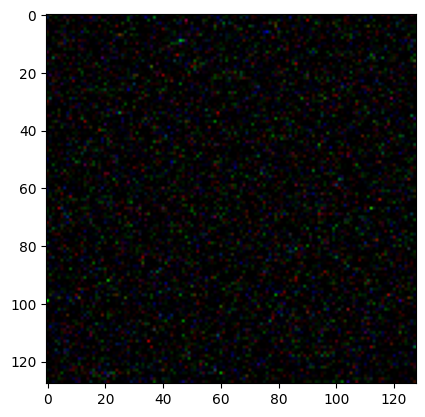

1.0 -1.0
-0.0294195944678623 0.10861310325933896


In [262]:
np.random.seed(SEED)

perturbation_factor = 30
rand_arr = np.random.laplace(size=(128, 128, 3))
# minmax norm rand array between 0 and 1
rand_norm = (rand_arr-np.min(rand_arr))/(np.max(rand_arr)-np.min(rand_arr))
# multiply by 2 and shift to -1 to 1
rand_norm = (rand_norm*2)-1.0

plt.imshow(rand_norm)
plt.show()


print(np.max(rand_norm), np.min(rand_norm))
print(np.mean(rand_norm), np.std(rand_norm))

In [12]:
def get_perturbation(size: tuple[int], dist: str = 'laplace'):
    if dist == 'laplace':
        rand_loc = np.random.uniform(-3.0, 3.0)
        rand_arr = np.random.laplace(loc=rand_loc, scale=2.0, size=size)
        rand_arr = np.clip(rand_arr, -9.0, 9.0)
        # arr_mean = np.mean(rand_arr)
        # rand_arr = np.clip(rand_arr, -arr_mean, arr_mean)
    else:
        raise NotImplementedError(f"distribution type '{dist}' not implemented yet")

    # minmax norm rand array between 0 and 1
    # rand_arr = rand_arr**1.1
    rand_norm = (rand_arr-np.min(rand_arr))/(np.max(rand_arr)-np.min(rand_arr))
    # rand_dir_arr = rand_norm > 0.0
    rand_norm = rand_norm**3
    rand_norm = 1.0 - rand_norm
    # multiply by 2 and shift to -1 to 1
    # rand_norm = (rand_norm*2)-1.0

    return rand_norm

## 2.3 Entropy Metric Analysis

In [19]:
import numpy as np

def calculate_stack_entropy(arr_stack):
    total_entropy = 0.0

    for arr in arr_stack:
        flat_arr = arr.flatten()
        if isinstance(flat_arr, np.ndarray):
            flat_arr = torch.tensor(flat_arr)
        
        # normalize to a probability distribution
        prob_arr = (flat_arr+1e-6) / flat_arr.sum()
        
        # calculate the entropy for this arr
        entropy_arr = -torch.sum(prob_arr * torch.log2(prob_arr))
        total_entropy += entropy_arr.item()

    return total_entropy

image_entropy_list = []
caption_entropy_list = []
ioe_ratio_list = []
for image_results in tqdm(lsa_result_list5):
    image_list = [i['image'] for i in image_results]
    caps_list = [i['ids'] for i in image_results]

    _, pad_cap_arr = standardize_dims(image_list, caps_list)
    image_entropy = calculate_stack_entropy(image_list)
    caption_entropy = calculate_stack_entropy(pad_cap_arr)

    image_entropy_list.append(image_entropy)
    caption_entropy_list.append(caption_entropy)
    # input-output entropy ratio (ioe ratio)
    ioe_ratio_list.append((caption_entropy**2)/image_entropy)


100%|██████████| 200/200 [00:01<00:00, 191.23it/s]


In [23]:
import pandas as pd
import seaborn as sns

In [24]:
label_list = [l[0]['label'].item() for l in lsa_result_list5]
member_list = ['member' if l == 1 else 'non-member' for l in label_list]

lsa_df = pd.DataFrame({
    'image_entropy': image_entropy_list, 
    'caption_entropy': caption_entropy_list, 
    'input_output_entropy_ratio': ioe_ratio_list, 
    'label': member_list,
})

for metric in ["input_output_entropy_ratio", "caption_entropy", "image_entropy"]:
    g = sns.FacetGrid(lsa_df, row='label', hue='label', aspect=9, height=1.2)
    g.map(kde_w_conf, metric)
    g.map(label, metric)
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=False, left=True)
    
    plt.suptitle(f"{metric.replace('_', ' ').title()} vs Membership Status")
    plt.show()

    fpr, tpr, mia_auroc = plot_roc_mia(
        lsa_df[metric].tolist(), 
        label_list, 
        metric.replace('_', ' ').title()
    )
    tpr_fpr_dict = get_tpr_fpr_dict(tpr, fpr)
    print("\n\n")

## 2.4 Distance Metric Analysis

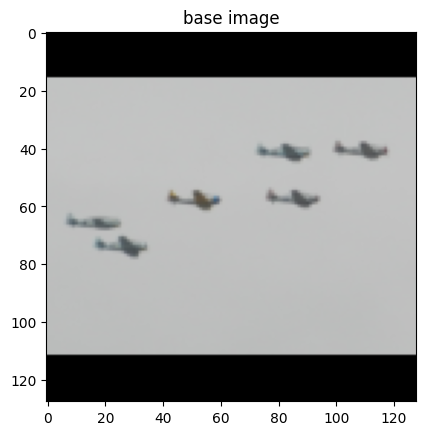

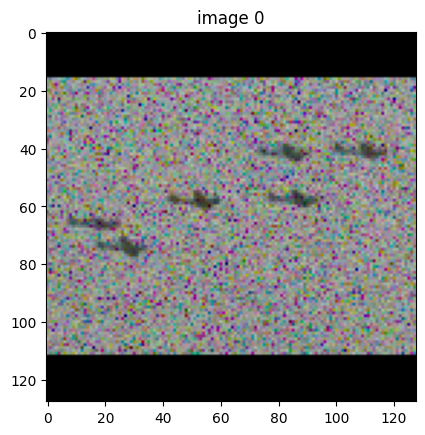

image 0 cosine similarity: 0.0


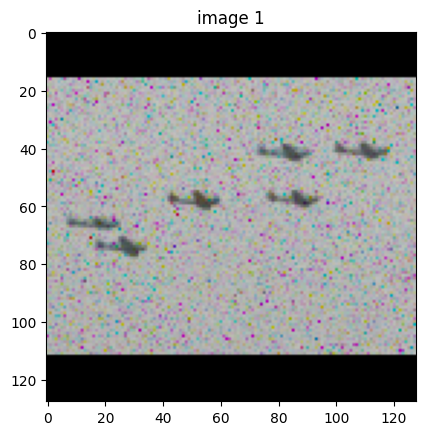

image 1 cosine similarity: 0.0


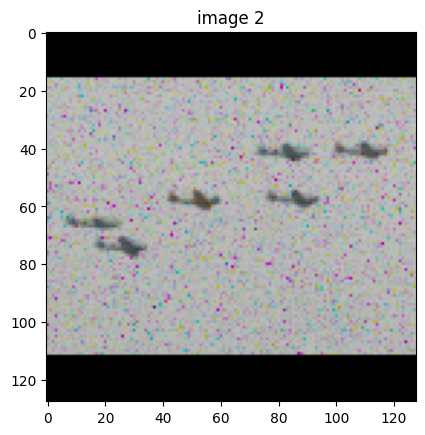

image 2 cosine similarity: 0.0


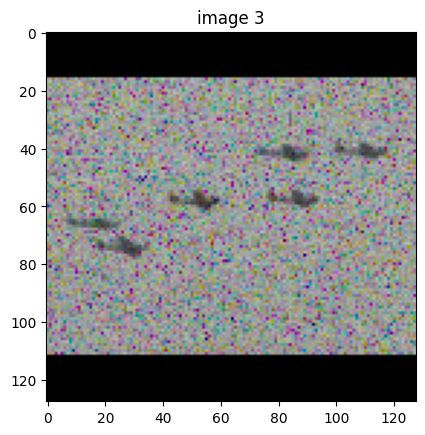

image 3 cosine similarity: 0.0


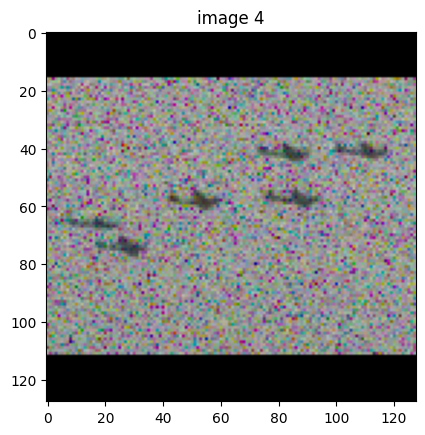

image 4 cosine similarity: 0.0


In [167]:
# lsa_obj = _result_list[0]

plt.imshow(cv.cvtColor(np.moveaxis(lsa_obj.base['image_arr'].reshape(3, 128, 128), 0, 2), cv.COLOR_BGR2RGB))
plt.title('base image')
plt.show()


for i, perturbed_dict in enumerate(lsa_obj.perturbed_list):
    plt.imshow(cv.cvtColor(np.moveaxis(perturbed_dict['image_arr'].reshape(3, 128, 128), 0, 2), cv.COLOR_BGR2RGB))
    plt.title(f'image {i}')
    plt.show()
    cos_sim = cosine(
        lsa_obj.base['image_arr'], 
        perturbed_obj['image_arr']
    )
    print(f'image {i} cosine similarity: {cos_sim}')

In [173]:
def evaluate_distance_lsa(result_list: list, distance_metric: str, agg_type: str):
    _result_list = result_list.copy()

    _label_list = [l[0]['label'].item() for l in _result_list]
    _member_list = ['member' if l == 1 else 'non-member' for l in _label_list]

    print(f"Evaluating with metric: {distance_metric} {agg_type}")
    # for agg_type in ['mean', 'median', 'std']:
    # get lsa distance
    io_distance_list = []
    for lsa_image_list in _result_list:
        lsa_obj = LSAImage(lsa_image_list)
        io_distance_list.append(
            lsa_obj.get_metric(distance_metric)
        )
        
    # aggregate distances
    agg_io_distance_list = []
    for io_dist_dict in io_distance_list:
        item_dict = {}
        for k,v in io_dist_dict.items():
            if agg_type == 'mean':
                item_dict[k] = np.mean(v)
            elif agg_type == 'median':
                item_dict[k] = np.median(v)
            elif agg_type == 'std':
                item_dict[k] = np.std(v)
            else:
                raise NotImplementedError(f"agg. type {agg_type} not implemented")
                
        agg_io_distance_list.append(item_dict)


    _input_dists = [d['input'] for d in agg_io_distance_list]
    _output_dists = [d['output'] for d in agg_io_distance_list]
    
    _lsa_df = pd.DataFrame({
        'input': _input_dists, 
        'output': _output_dists,
        'label': _member_list,
    })
    
    _lsa_df['io_ratio'] = _lsa_df['input']/(_lsa_df['output']+1e-6)
    _lsa_df['oi_ratio'] = _lsa_df['output']/(_lsa_df['input']+1e-6)
    
    for metric in [c for c in _lsa_df.columns if c != "label"]:
        mia_type = f"{agg_type.title()} {metric.replace('_', ' ').title()} {distance_metric.replace('_', ' ').title()}"
        print(f"Attack Signal: {mia_type}")
        g = sns.FacetGrid(_lsa_df, row='label', hue='label', aspect=9, height=1.2)
        g.map(kde_w_conf, metric)
        g.map(label, metric)
        g.set_titles("")
        g.set(yticks=[], ylabel="")
        g.despine(bottom=False, left=True)
        
        plt.suptitle(f"{mia_type} vs Membership Status")
        plt.show()
    
        fpr, tpr, mia_auroc = plot_roc_mia(
            _lsa_df[metric].tolist(), 
            label_list, 
            mia_type
        )
        tpr_fpr_dict = get_tpr_fpr_dict(tpr, fpr)
        print("\n\n")
        plt.show()

### 2.4.1 Cosine Distance

### 2.4.1a Mean

Evaluating with metric: cosine_distance mean
Attack Signal: Mean Input Cosine Distance


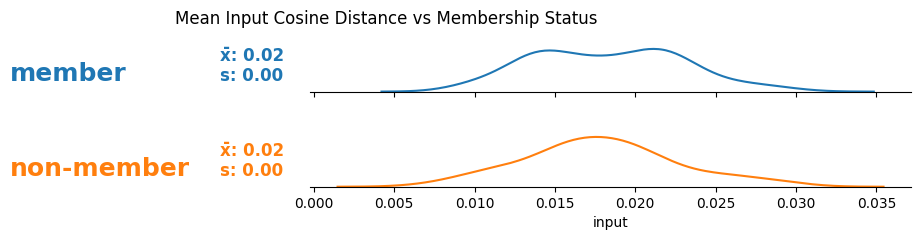

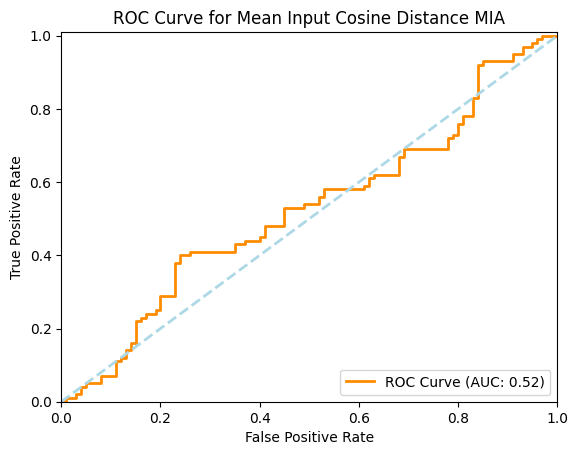




Attack Signal: Mean Output Cosine Distance


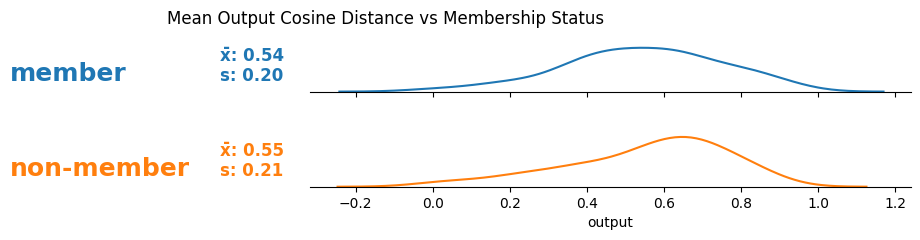

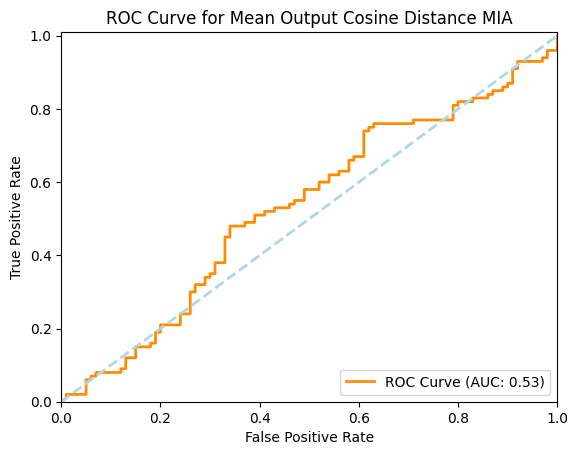




Attack Signal: Mean Io Ratio Cosine Distance


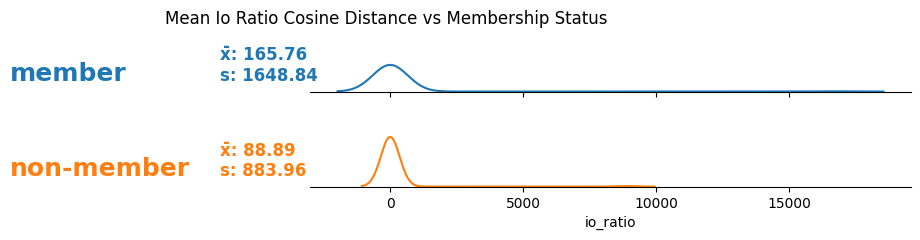

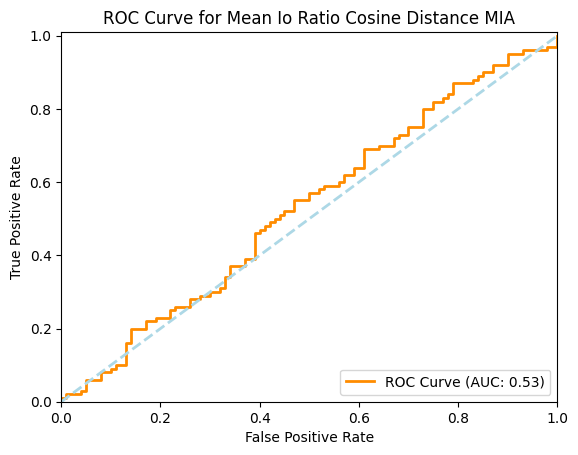




Attack Signal: Mean Oi Ratio Cosine Distance


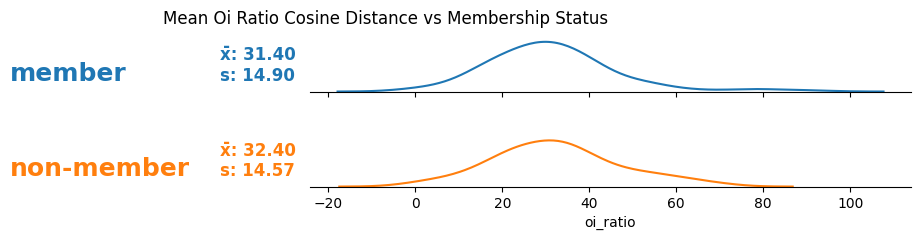

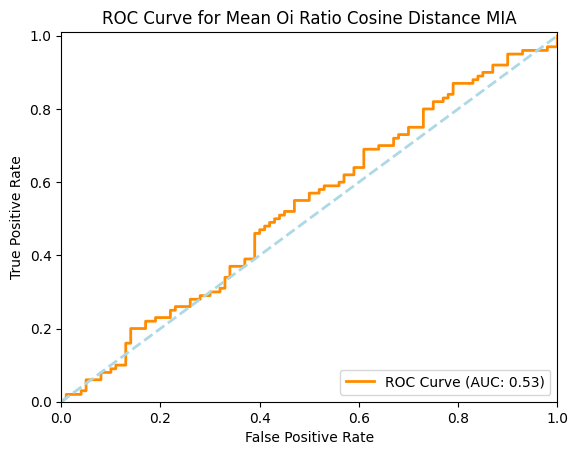

In [174]:
distance_metric = "cosine_distance"
evaluate_distance_lsa(lsa_result_list5, distance_metric, "mean")

### 2.4.1b Median

Evaluating with metric: cosine_distance median
Attack Signal: Median Input Cosine Distance


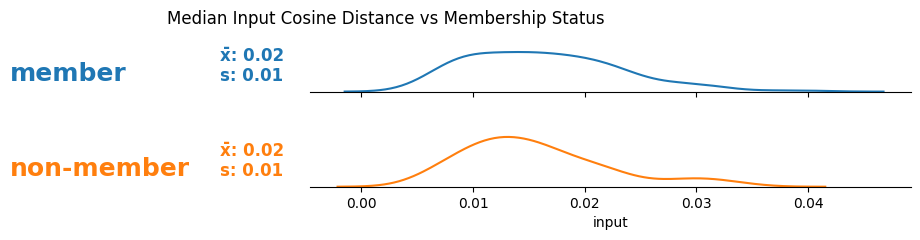

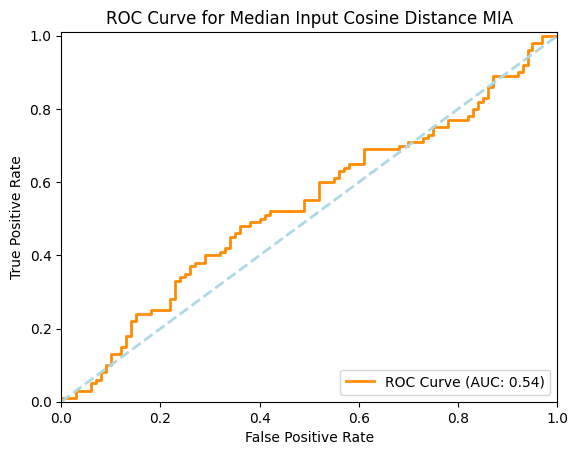




Attack Signal: Median Output Cosine Distance


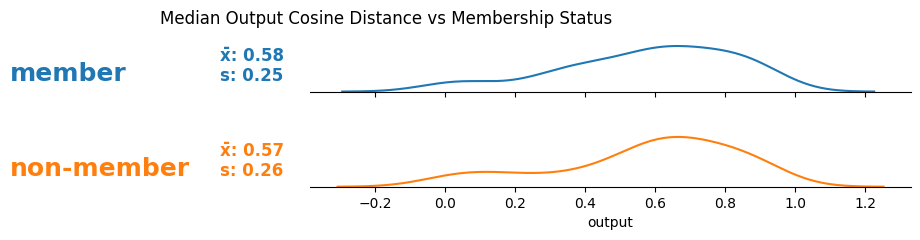

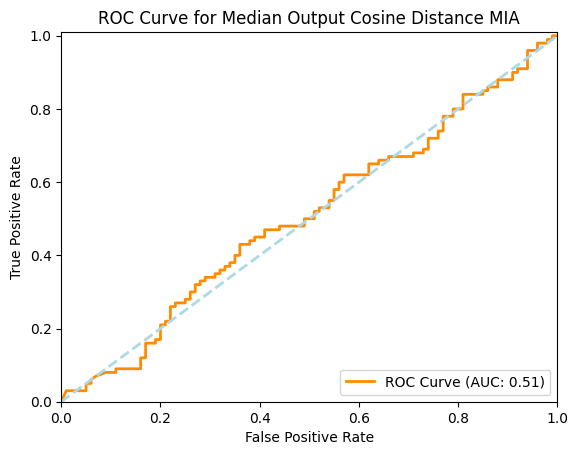




Attack Signal: Median Io Ratio Cosine Distance


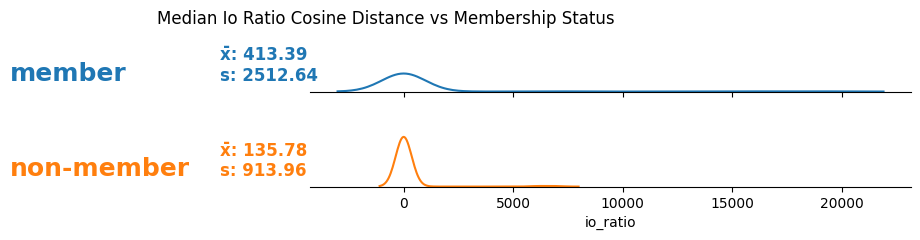

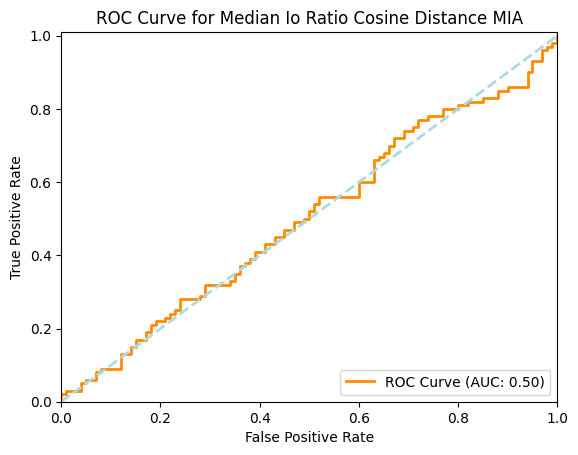




Attack Signal: Median Oi Ratio Cosine Distance


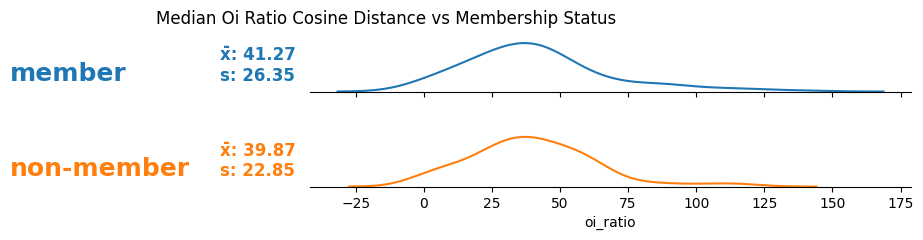

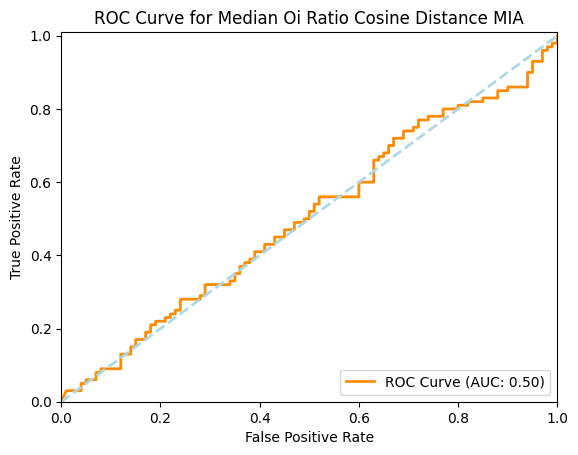

In [175]:
evaluate_distance_lsa(lsa_result_list5, distance_metric, "median")

### 2.4.1c Standard Deviation

Evaluating with metric: cosine_distance std
Attack Signal: Std Input Cosine Distance


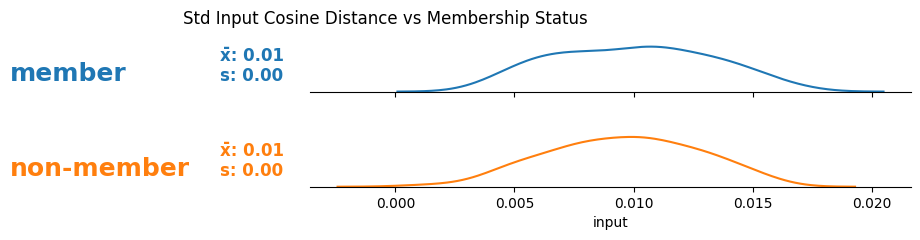

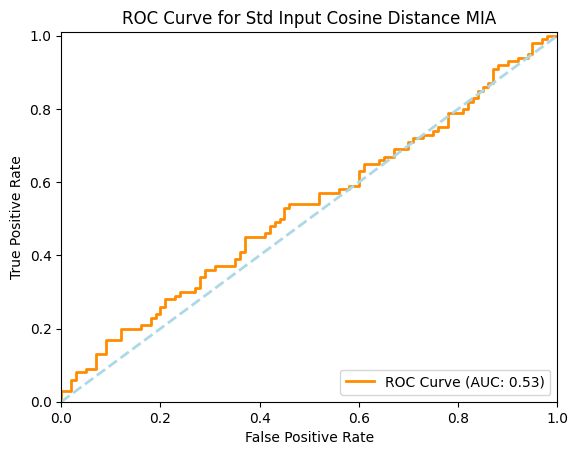




Attack Signal: Std Output Cosine Distance


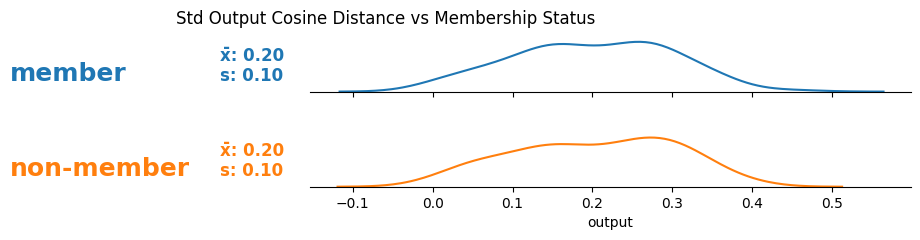

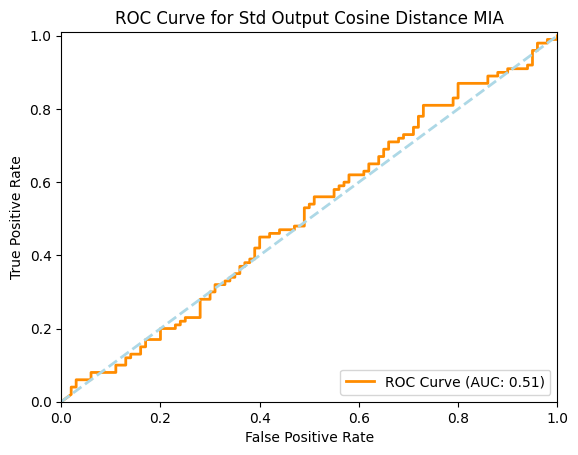




Attack Signal: Std Io Ratio Cosine Distance


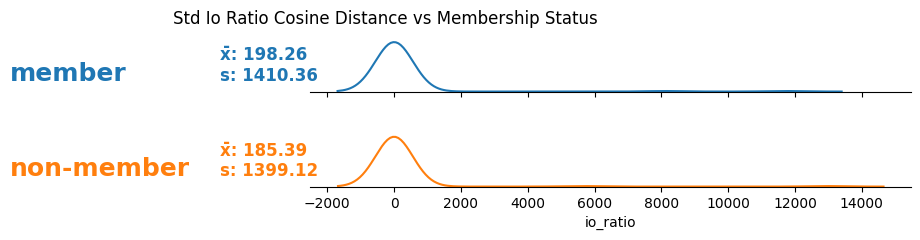

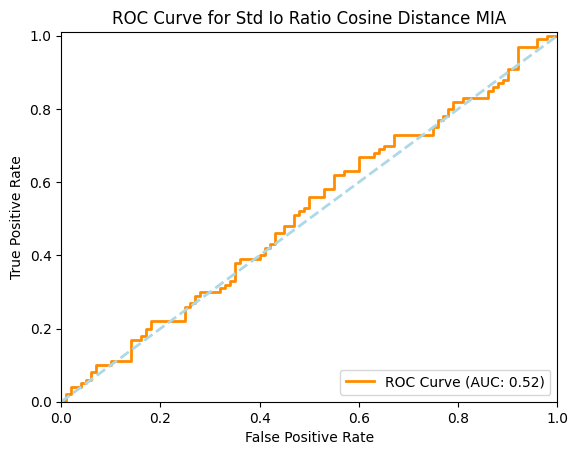




Attack Signal: Std Oi Ratio Cosine Distance


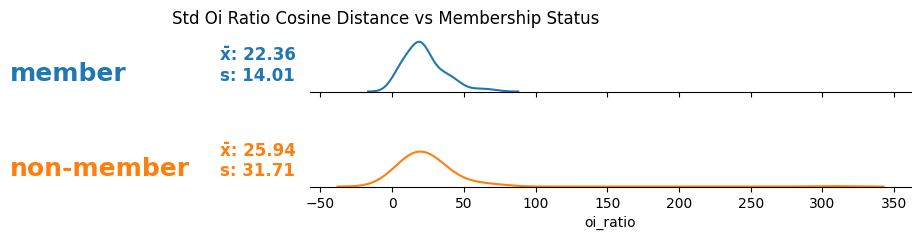

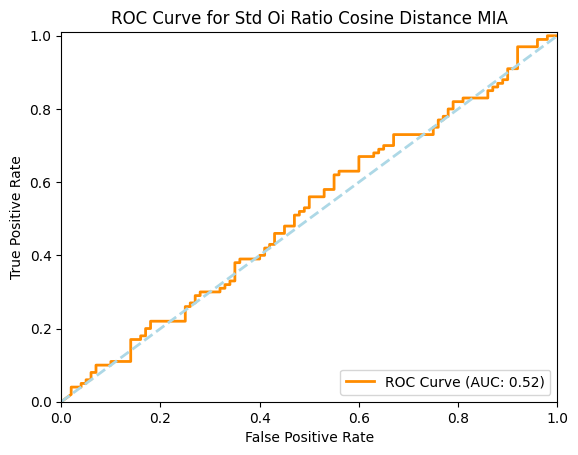

In [176]:
evaluate_distance_lsa(lsa_result_list5, distance_metric, "std")

In [125]:
_lsa_df['input'] = _lsa_df['output']

## Cosine Distance

### Mean Cosine Distance

In [100]:
mean_io_distance_list = []
for io_dist_dict in io_distance_list:
    item_dict = {}
    for k,v in io_dist_dict.items():
        item_dict[k] = np.mean(v)
    mean_io_distance_list.append(item_dict)

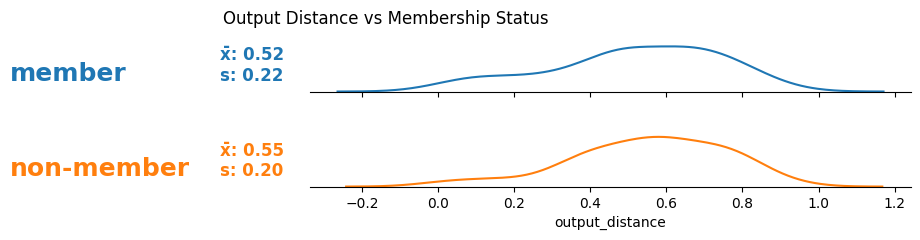

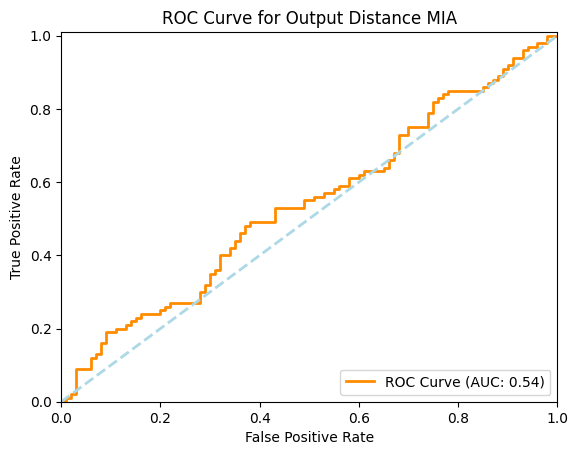

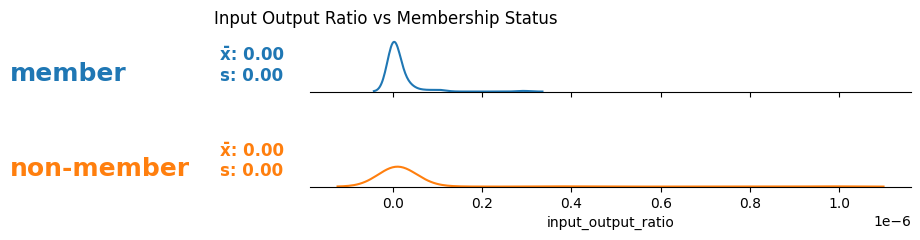

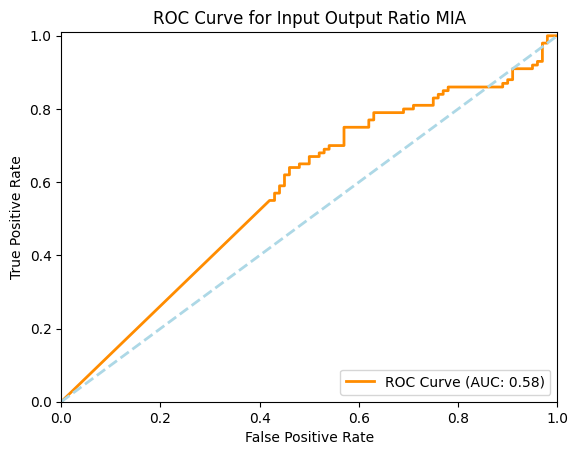

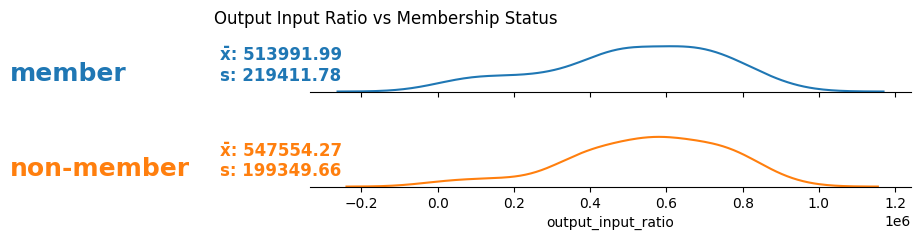

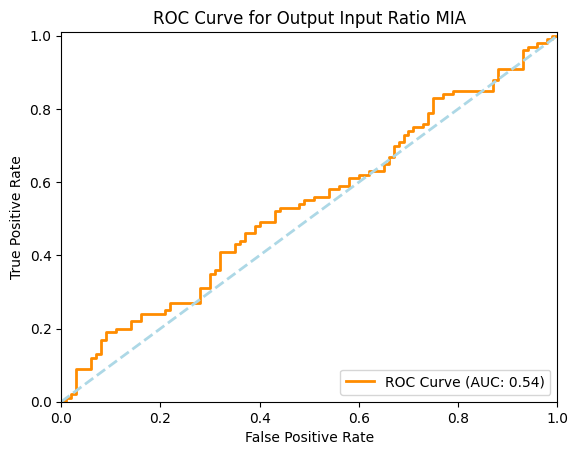

In [106]:
label_list = [l[0]['label'].item() for l in lsa_result_list5]
member_list = ['member' if l == 1 else 'non-member' for l in label_list]

mean_input_dists = [d['input'] for d in mean_io_distance_list]
mean_output_dists = [d['output'] for d in mean_io_distance_list]

lsa_mean_dist_df = pd.DataFrame({
    'input_distance': mean_input_dists, 
    'output_distance': mean_output_dists,
    'label': member_list,
})

lsa_mean_dist_df['input_output_ratio'] = lsa_mean_dist_df['input_distance']/(lsa_mean_dist_df['output_distance']+1e-6)
# lsa_mean_dist_df['output_input_ratio'] = lsa_mean_dist_df['output_distance']/(lsa_mean_dist_df['input_distance']+1e-6)

for metric in ["output_distance", "input_output_ratio", "output_input_ratio"]:
    g = sns.FacetGrid(lsa_mean_dist_df, row='label', hue='label', aspect=9, height=1.2)
    g.map(kde_w_conf, metric)
    g.map(label, metric)
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=False, left=True)
    
    plt.suptitle(f"{metric.replace('_', ' ').title()} vs Membership Status")
    plt.show()

    fpr, tpr, mia_auroc = plot_roc_mia(
        lsa_mean_dist_df[metric].tolist(), 
        label_list, 
        metric.replace('_', ' ').title()
    )
    tpr_fpr_dict = get_tpr_fpr_dict(tpr, fpr)
    print("\n\n")

### Median Cosine Distance

In [107]:
median_io_distance_list = []
for io_dist_dict in io_distance_list:
    item_dict = {}
    for k,v in io_dist_dict.items():
        item_dict[k] = np.median(v)
    median_io_distance_list.append(item_dict)

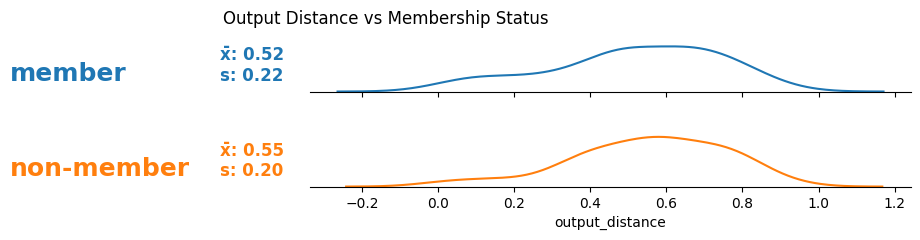

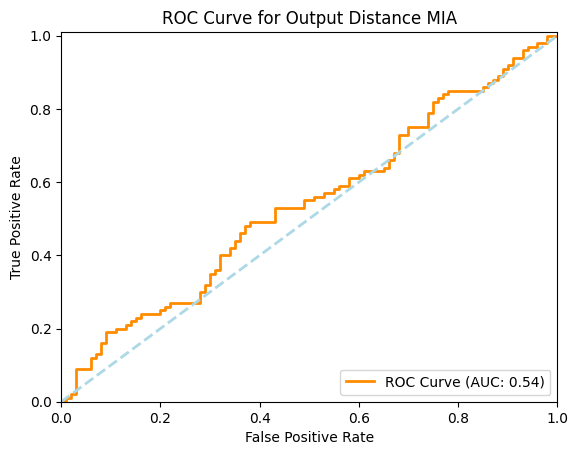

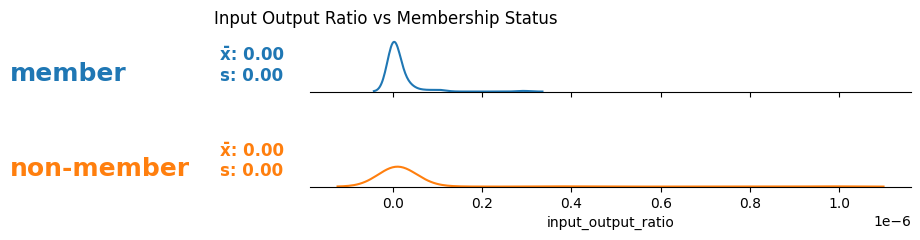

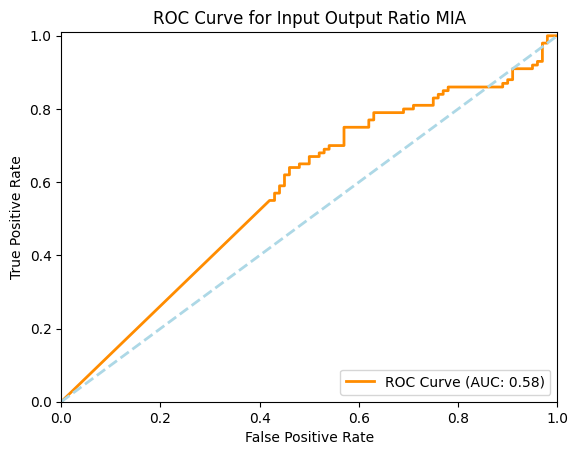

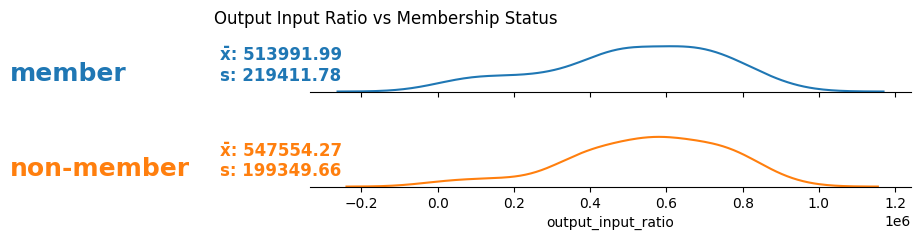

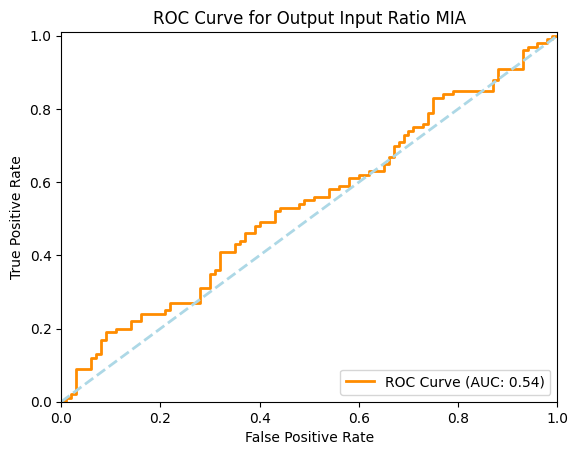

In [106]:
label_list = [l[0]['label'].item() for l in lsa_result_list5]
member_list = ['member' if l == 1 else 'non-member' for l in label_list]

mean_input_dists = [d['input'] for d in mean_io_distance_list]
mean_output_dists = [d['output'] for d in mean_io_distance_list]

lsa_mean_dist_df = pd.DataFrame({
    'input_distance': mean_input_dists, 
    'output_distance': mean_output_dists,
    'label': member_list,
})

lsa_mean_dist_df['input_output_ratio'] = lsa_mean_dist_df['input_distance']/(lsa_mean_dist_df['output_distance']+1e-6)
# lsa_mean_dist_df['output_input_ratio'] = lsa_mean_dist_df['output_distance']/(lsa_mean_dist_df['input_distance']+1e-6)

for metric in ["output_distance", "input_output_ratio", "output_input_ratio"]:
    g = sns.FacetGrid(lsa_mean_dist_df, row='label', hue='label', aspect=9, height=1.2)
    g.map(kde_w_conf, metric)
    g.map(label, metric)
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=False, left=True)
    
    plt.suptitle(f"{metric.replace('_', ' ').title()} vs Membership Status")
    plt.show()

    fpr, tpr, mia_auroc = plot_roc_mia(
        lsa_mean_dist_df[metric].tolist(), 
        label_list, 
        metric.replace('_', ' ').title()
    )
    tpr_fpr_dict = get_tpr_fpr_dict(tpr, fpr)
    print("\n\n")